# Train an agent to play Cliff Walking using Q-learning


[Gymnasium](https://gymnasium.farama.org) is a toolkit for developing and comparing reinforcement algorithms. It contains several test problem (*environments*) that have a shared interface, allowing you to write general algorithms. 

Let's start with importing all necessary dependencies.

In [26]:
import gym
import numpy as np
import random
from enum import Enum

In [ ]:
!pip install 'gymnasium[classic-control]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.3
    Uninstalling numpy-2.2.3:
      Successfully uninstalled numpy-2.2.3


## Description of the game

The Cliff Walking environment in Gymnasium (previously part of OpenAI Gym) is like this:

Imagine a grid — like a checkerboard — where you start in the bottom-left corner.
Your goal is to reach the bottom-right corner.
But! Between you and the goal, along the bottom row, is a cliff — a dangerous area.
If you step into the cliff, you "fall off," get a big negative reward (penalty), and you’re sent back to the start.
If you manage to walk safely around the cliff and reach the goal, you win.
More details:

Each move (up, down, left, right) gives a small penalty (like -1 reward) because they want to encourage you to find the fastest route.
Falling off the cliff gives a huge penalty (like -100).
The "safe" path is usually to move right across the second-to-last row, and only at the end move down carefully to the goal.

More info on: https://gymnasium.farama.org/environments/toy_text/cliff_walking/

In [27]:
env = gym.make("CliffWalking-v0")

## Initialize the Q-table 

Remember: 
- number of rows: number of states
- number of columns: number of actions
q-table: np array of dimension (states, actions)

add some things on how to make np arrays

In [28]:
state_space_size = env.observation_space.n
action_space_size = env.action_space.n
print(f"State space size: {state_space_size}")

State space size: 48


In [29]:
q_table = np.zeros((state_space_size, action_space_size))
print(f"Q-table shape: {q_table.shape}")

Q-table shape: (48, 4)


In [30]:
q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


## Set the hyperparameters

In [31]:
discount_factor = 0.99
learning_rate = 0.1

initial_exploration_rate = 1.0
min_exploration_rate = 0.01
exploration_rate = 1
exploration_decay_rate = 0.001

num_episodes = 10000
max_steps_per_episode = 100

## Train the agent

Store the total rewards for each episode. This is for diagnostics.

In [32]:
rewards = np.zeros(num_episodes) 

In each episode:
1.   Reset environment
2.   For each step in the episode:
  - pick an action $a$ by generating a random float $r$ in $[0,1]$
    - if $r > \epsilon$ we choose the next action by exploitation
    - if $r \leq \epsilon$ we choose the next action by exploration
  - take action $a$ and observe reward $R$ and next state $s'$
  - update Q-table 
  $$ q(s,a) = q(s,a) + \alpha(R + \gamma max_{a'} q(s', a') - q(s,a)) $$
3. decrease exploration rate proportional to its current value, we will use exponential decay: 
$$N(t) = N_0 e^{-\lambda t}$$
where $N_0$ is the initial quantity and $N(t)$ is the quantity at time step $t$.



with 
- $\epsilon$ the exploration rate,
- $\lambda$ the exploration rate decay,
- $\alpha$ the learning rate and 
- $\gamma$ the discount factor.









In [34]:
for episode in range(num_episodes):
    state = env.reset()[0]
    reward_episode = 0

    for step in range(max_steps_per_episode):
        # Exploration vs Exploitation
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state])
        else:
            action = env.action_space.sample()
        # Take action
        new_state, reward, terminated, truncated, info = env.step(action)

        done = terminated or truncated

        # Update Q-table
        q_table[state, action] += learning_rate * (reward + discount_factor * np.max(q_table[new_state]) - q_table[state, action])

        # Update state
        state = new_state
        reward_episode += reward
        if done:
            break

        rewards[episode] = reward_episode

    # Exploration rate decay
    exploration_rate = max(initial_exploration_rate * np.exp(-exploration_decay_rate * episode), min_exploration_rate)

Let's print the average reward per thousand episodes, this way we can get an idea about how rewards have changed over time.

In [35]:
rewards_per_thousand_episodes = np.split(rewards, num_episodes / 1000)

Let's also visualize the *learning curve* by plotting the moving average using a window length of 1000.

In [36]:
count = 1000
for r in rewards_per_thousand_episodes:
    print("after ", count, " episodes: ", np.average(r))    
    count += 1000

after  1000  episodes:  -551.304
after  2000  episodes:  -135.774
after  3000  episodes:  -44.147
after  4000  episodes:  -22.1
after  5000  episodes:  -14.823
after  6000  episodes:  -14.485
after  7000  episodes:  -14.537
after  8000  episodes:  -15.776
after  9000  episodes:  -14.712
after  10000  episodes:  -14.252


In [37]:
def moving_average(array, window):
    return np.convolve(array, np.ones(window), 'valid') / window

In [38]:
moving_average(rewards, 1000)

array([-551.304, -550.829, -550.056, ...,  -14.252,  -14.252,  -14.252],
      shape=(9001,))

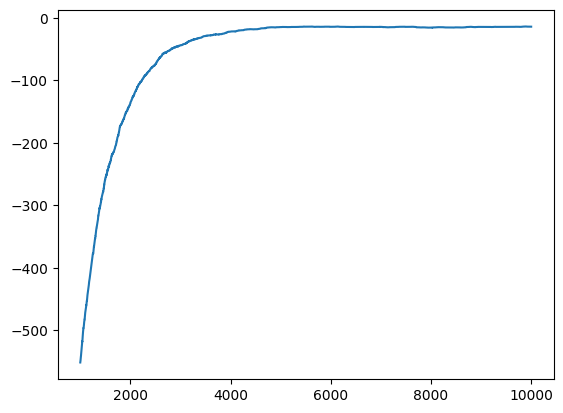

In [39]:
import matplotlib.pyplot as plt
plt.plot(np.arange(999, 10000), moving_average(rewards, 1000))
plt.show()

## Optimal policy

Let's print the q_table.

In [40]:
q_table

array([[ -13.49888488,  -13.10117112,  -13.10205649,  -13.60827457],
       [ -12.90115738,  -12.24387236,  -12.24409359,  -13.6911842 ],
       [ -12.13385665,  -11.3605006 ,  -11.3605481 ,  -13.04101356],
       [ -11.32215161,  -10.465809  ,  -10.4658017 ,  -12.1579141 ],
       [ -10.45560886,   -9.56161511,   -9.56162685,  -11.31610919],
       [  -9.54574599,   -8.64819905,   -8.64820004,  -10.45156803],
       [  -8.63600084,   -7.72548687,   -7.72549023,   -9.54811828],
       [  -7.71450206,   -6.79343815,   -6.79343973,   -8.63322037],
       [  -6.77695765,   -5.851973  ,   -5.85197332,   -7.70640518],
       [  -5.77949288,   -4.9009896 ,   -4.90098976,   -6.7616875 ],
       [  -4.88536742,   -3.94039749,   -3.94039742,   -5.78799926],
       [  -3.92493247,   -3.89851901,   -2.97009999,   -4.85149692],
       [ -13.94450489,  -12.2478977 ,  -12.2478977 ,  -13.12416026],
       [ -13.11659227,  -11.36151283,  -11.36151283,  -13.12513457],
       [ -12.2451352 ,  -10.466174

Let's use the learned q_table to define the policy. Name the method `policy`.

In [41]:
def policy(state):
    return np.argmax(q_table[state])

Let's use an Enum to print out nicely which action to take in which state. 

In [42]:
class Action(Enum):

    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3

In [43]:
for state in range(state_space_size):
    print("state: ", state, " action to take: ", Action(policy(state)).name)

state:  0  action to take:  DOWN
state:  1  action to take:  DOWN
state:  2  action to take:  DOWN
state:  3  action to take:  RIGHT
state:  4  action to take:  DOWN
state:  5  action to take:  DOWN
state:  6  action to take:  DOWN
state:  7  action to take:  DOWN
state:  8  action to take:  DOWN
state:  9  action to take:  DOWN
state:  10  action to take:  RIGHT
state:  11  action to take:  RIGHT
state:  12  action to take:  DOWN
state:  13  action to take:  DOWN
state:  14  action to take:  RIGHT
state:  15  action to take:  DOWN
state:  16  action to take:  RIGHT
state:  17  action to take:  DOWN
state:  18  action to take:  RIGHT
state:  19  action to take:  RIGHT
state:  20  action to take:  DOWN
state:  21  action to take:  DOWN
state:  22  action to take:  DOWN
state:  23  action to take:  RIGHT
state:  24  action to take:  DOWN
state:  25  action to take:  DOWN
state:  26  action to take:  DOWN
state:  27  action to take:  DOWN
state:  28  action to take:  DOWN
state:  29  acti

## Play Cliff Walking

Let's play Cliff Walking for `num_episodes` times and check how well our learned policy does on average. How does it compare to your handcoded policy?

In [44]:
rewards_test = np.zeros(num_episodes)

for episode in range(num_episodes):
    state = env.reset()[0]
    for step in range(max_steps_per_episode):
        state, reward, terminated, truncated, info = env.step(policy(state))
        rewards_test[episode] += reward
        done = terminated or truncated
        if done:
            break

In [45]:
np.mean(rewards_test)

np.float64(-13.0)

Play the cliff walking game in a (rendered) human environment:

In [46]:
from IPython.display import clear_output
import time



In [ ]:
env = gym.make("CliffWalking-v0", render_mode="human")
state = env.reset()[0]
prind(env.render())

for step in range(max_steps_per_episode):
    time.sleep(0.5)
    state, reward, terminated, truncated, info = env.step(policy(state))
    terminated = bool(terminated)
    truncated = bool(truncated)
    frame = env.render()  # This returns the current frame as an array
    done = terminated or truncated
    if done:
        break

if state == 47:
    print("You reached the goal!")
else:
    print("You fell off the cliff!")

AttributeError: module 'numpy' has no attribute 'bool8'

In [ ]:
env.close()